In [1]:
pip install torch torchvision torchaudio torch-geometric scikit-learn


  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   --------------------------------- ------ 1.3/1.6 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 1.6/204.2 MB 8.4 MB/s eta 0:00:25
    --------------------------------------- 3.1/204.2 MB 8.0 MB/s eta 0:00:26
    --------------------------------------- 4.7/204.2 MB 7.7 MB/s eta 0:00:26
   - -------------------------------------- 6.3/204.2 MB 7.7 MB/s eta 0:00:26
   - -------------------------------------- 7.9/204.2 MB 7.6 MB/s eta 0:00:26
   - -------------------------------------- 9.4/204.2 MB 7.5 MB/s eta 0:00:26
   -- ------------------------------------- 11.0/204.2 MB 7.6 MB/s eta 0:00:26
   -- ------------------------------------- 12.

DEPRECATION: Loading egg at e:\anaconda\envs\text_analytics\lib\site-packages\huggingface_hub-0.28.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
import scipy.io
import numpy as np

# === Load Data ===
train_mat = scipy.io.loadmat("train_normalised.mat")['test_normalised']
test_mat = scipy.io.loadmat("test_normalised.mat")['test_normalised']

X_train = torch.tensor(train_mat, dtype=torch.float32)
X_test = torch.tensor(test_mat, dtype=torch.float32)

# === Simulate Labels ===
y_train = torch.tensor([0]*10 + [1]*10, dtype=torch.long)
y_test = torch.tensor([0]*110 + [1]*110, dtype=torch.long)

# === Combine for Graph Creation ===
X = torch.cat([X_train, X_test], dim=0)
y = torch.cat([y_train, y_test], dim=0)
num_train = len(X_train)

# === Build Graph using k-NN ===
knn_graph = kneighbors_graph(X, n_neighbors=5, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)

# === Build PyG Data Object ===
data = Data(x=X, edge_index=edge_index, y=y)
data.train_mask = torch.zeros(y.shape[0], dtype=torch.bool)
data.train_mask[:num_train] = True
data.test_mask = ~data.train_mask

# === Define GCN Model ===
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(in_channels=5880, hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# === Training Loop ===
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[data.test_mask].argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].cpu(), pred.cpu())
    return acc

# === Run Training ===
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")


Epoch 020, Loss: 0.6585, Test Acc: 0.5000
Epoch 040, Loss: 0.6522, Test Acc: 0.5591
Epoch 060, Loss: 0.6361, Test Acc: 0.5318
Epoch 080, Loss: 0.6292, Test Acc: 0.5364
Epoch 100, Loss: 0.6225, Test Acc: 0.5000
Epoch 120, Loss: 0.6149, Test Acc: 0.5000
Epoch 140, Loss: 0.6165, Test Acc: 0.5000
Epoch 160, Loss: 0.6060, Test Acc: 0.5000
Epoch 180, Loss: 0.5994, Test Acc: 0.5000
Epoch 200, Loss: 0.5925, Test Acc: 0.5000


In [11]:
y_train

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
train_data = scipy.io.loadmat('train_normalised.mat')
test_data = scipy.io.loadmat('test_normalised.mat')

X_train = train_data['data']  # shape: (num_train_samples, num_features)
y_train = train_data['label'].flatten()  # shape: (num_train_samples,)

X_test = test_data['data']
y_test = test_data['label'].flatten()

# Combine and create dataset
X = np.vstack([X_train, X_test])
y = np.concatenate([y_train, y_test])
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Cosine similarity graph
cos_sim = cosine_similarity(X)
k = 5
adj_matrix = np.zeros_like(cos_sim)
for i in range(cos_sim.shape[0]):
    top_k = np.argsort(cos_sim[i])[-(k+1):-1]  # ignore self
    adj_matrix[i, top_k] = 1

edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# Define train/test masks
num_train = X_train.shape[0]
train_mask = torch.zeros(X.shape[0], dtype=torch.bool)
test_mask = torch.zeros(X.shape[0], dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

# Create PyG Data object
data = Data(x=X, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

# Define deeper GCN Model
class DeepGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DeepGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.conv3 = GCNConv(hidden_channels // 2, out_channels)
        self.dropout = torch.nn.Dropout(p=0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize model
model = DeepGCN(data.num_node_features, 64, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()

# Train
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluate
def test():
    model.eval()
    out = model(data)
    pred = out[data.test_mask].argmax(dim=1)
    acc = (pred == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc

# Run training
losses = []
accuracies = []
for epoch in range(1, 201):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Test Accuracy", color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'data'

In [6]:


import scipy.io

# Load and inspect contents
train_data = scipy.io.loadmat('train_normalised.mat')
test_data = scipy.io.loadmat('test_normalised.mat')

print("Train keys:", train_data.keys())
print("Test keys:", test_data.keys())


Train keys: dict_keys(['__header__', '__version__', '__globals__', 'test_normalised'])
Test keys: dict_keys(['__header__', '__version__', '__globals__', 'test_normalised'])


In [8]:
# Inspect the structure of the train and test data
train_struct = train_data['test_normalised']
test_struct = test_data['test_normalised']

print("Train struct fields:", train_struct.dtype)


Train struct fields: float64


In [9]:
print("Train shape:", train_struct.shape)
print("Test shape:", test_struct.shape)


Train shape: (20, 5880)
Test shape: (220, 5880)


Epoch 020, Loss: 0.6934, Test Acc: 0.5000
Epoch 040, Loss: 0.6932, Test Acc: 0.5000
Epoch 060, Loss: 0.6931, Test Acc: 0.5000
Epoch 080, Loss: 0.6931, Test Acc: 0.5000
Epoch 100, Loss: 0.6931, Test Acc: 0.5000
Epoch 120, Loss: 0.6931, Test Acc: 0.5000
Epoch 140, Loss: 0.6931, Test Acc: 0.5000
Epoch 160, Loss: 0.6931, Test Acc: 0.5000
Epoch 180, Loss: 0.6931, Test Acc: 0.5000
Epoch 200, Loss: 0.6931, Test Acc: 0.5000


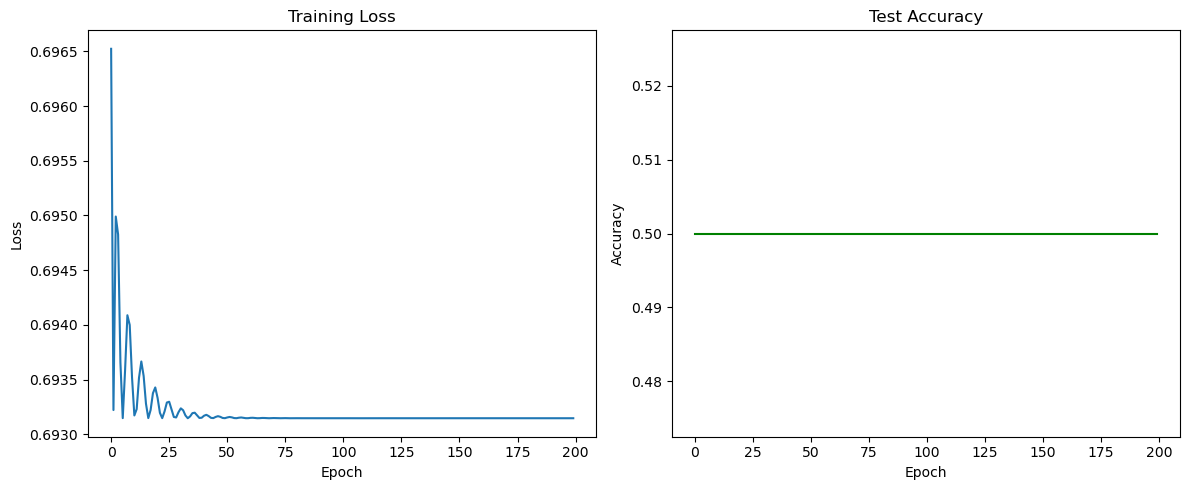

In [13]:
import numpy as np
import scipy.io
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Load data
train_data = scipy.io.loadmat('train_normalised.mat')['test_normalised']
test_data = scipy.io.loadmat('test_normalised.mat')['test_normalised']

X_train = train_data  # shape: (20, 5880)
y_train = np.array([0]*10 + [1]*10)

X_test = test_data    # shape: (220, 5880)
y_test = np.array([0]*110 + [1]*110)

# Convert to PyTorch tensors
X = torch.tensor(np.vstack((X_train, X_test)), dtype=torch.float)
y = torch.tensor(np.hstack((y_train, y_test)), dtype=torch.long)

# Train/test mask
train_mask = torch.zeros(X.shape[0], dtype=torch.bool)
test_mask = torch.zeros(X.shape[0], dtype=torch.bool)
train_mask[:len(X_train)] = True
test_mask[len(X_train):] = True

# Create a fully connected graph (for simplicity)
num_nodes = X.shape[0]
edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make it undirected

# PyG Data object
data = Data(x=X, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.test_mask = test_mask

# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(input_dim=5880, hidden_dim=64, output_dim=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
losses, accuracies = [], []
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = out[data.test_mask].max(dim=1)
    acc = pred.eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    losses.append(loss.item())
    accuracies.append(acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()
